# Autonecoder Example

https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [1]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import numpy as np

import matplotlib.pyplot as plt

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # Initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itelsf
        inputShape = (height, width, depth)
        chanDim = -1
        
        # Define inputs to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        
        # Loop over the number of filters
        for f in filters:
            # Apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # Flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        # Build the encoder model
        encoder = Model(inputs, latent, name='encoder')
        
        # Start building the decoder model which will accept the
        # output of the encoder and its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # Loop over our number of filter again, but this time in 
        # reverse order
        for f in filters[::-1]:
            # Apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        
        # Apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3,3), padding='same')(x)
        outputs = Activation("sigmoid")(x)
        
        # Build the decoder model
        decoder = Model(latentInputs, outputs, name='decoder')
        
        # Our autoencoder is the encoder + decoder
        autoencoder = Model(inputs,decoder(encoder(inputs)), name='autoencoder')
        
        # Return a 3-tuple of the encoder, decoder and autoencoder
        return (encoder, decoder, autoencoder)

In [3]:
# Set the maptplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

In [4]:
# Import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [6]:
# Initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

In [7]:
# Load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

[INFO] loading MNIST dataset...


In [8]:
# Add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32")/255.0
testX = testX.astype("float32")/255.0

In [9]:
# Construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28,28,1)
opt = Adam(lr=1e-3)

[INFO] building autoencoder...


In [10]:
autoencoder.compile(loss='mse', optimizer=opt)

In [11]:
# Train the convolutional autoencoder
H = autoencoder.fit(
    trainX, trainX,
    validation_data=(testX, testX),
    epochs=EPOCHS,
    batch_size=BS
)

Epoch 1/25
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0188 - val_loss: 0.0111
Epoch 2/25
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 3/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 4/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 5/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 6/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 7/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 8/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 9/25
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 10/25
1875/1875 [==============================] - 49s 26m

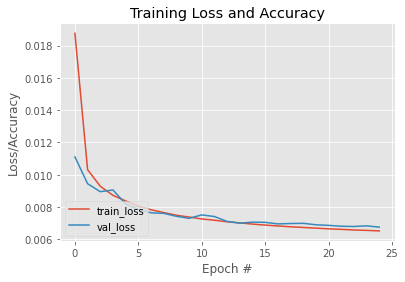

In [12]:
# Construct a plot that plots and saves the trainig history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig()
plt.show()

In [13]:
# Use the convolutional encoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO]making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

[INFO]making predictions...


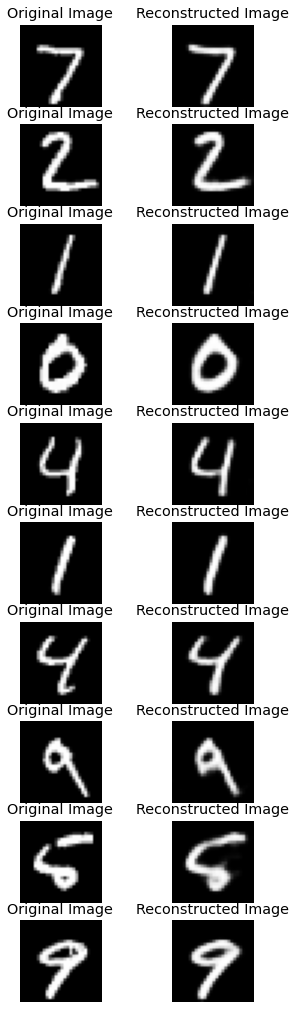

In [32]:
figsize = 5
samples_count = 10

fig, plot_grid = plt.subplots(samples_count, 2, figsize=(figsize, 18))

# Loop over the number of output samples
for i in range(0, samples_count):
    # Grab the original image and reconstruct image
    original = (testX[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    
    plot_grid[i][0].imshow(original, cmap = 'gray')
    plot_grid[i][0].set_title("Original Image")
    plot_grid[i][0].set_xticks([])
    plot_grid[i][0].set_yticks([])
    
    plot_grid[i][1].imshow(recon, cmap = 'gray')
    plot_grid[i][1].set_title("Reconstructed Image")
    plot_grid[i][1].set_xticks([])
    plot_grid[i][1].set_yticks([])